<b><h4>HW3 - Notebook: Multi-Layer perceptron</h4></b>

[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Authors__: Amir Ezzati & Ali Bavafa

Name: mobina kochaknia                
Student-ID:401106396

# Import & Helper Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gdown
from sklearn.datasets import fetch_openml
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import time
import random

from itertools import combinations_with_replacement

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display

In [2]:
def seed_setter(seed=None, seed_torch=True):
  """
  Function that controls randomness.

  Args:
    seed : Integer
      A non-negative integer that defines the random state.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):

  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: Instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot

  Returns:
    Nothing
  """
  net.train()
  train_losses = []
  for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.float()
      labels = labels.long()

      optimizer.zero_grad()
      outputs = net(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      if verbose:
        train_losses += [loss.item()]

  net.eval()

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
        Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.float()
      labels = labels.long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print(f'\nAccuracy on the {train_total} training samples: {train_acc:0.2f}')
    print(f'Accuracy on the {test_total} testing samples: {test_acc:0.2f}\n')

  if training_plot:
    plt.plot(train_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc


def shuffle_and_split_data(X, y, seed):
  """
  Helper function to shuffle and split data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  # Set seed for reproducibility
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[0]
  # Shuffle data
  shuffled_indices = torch.randperm(N)
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  test_size = int(0.2 * N)
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train


def sample_grid(M=500, x_max=2.0):
  """
  Helper function to simulate sample meshgrid

  Args:
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points

  Returns:
    X_all: torch.tensor
      Concatenated meshgrid tensor
  """
  ii, jj = torch.meshgrid(torch.linspace(-x_max, x_max,M),
                          torch.linspace(-x_max, x_max, M),
                          indexing='ij')
  X_all = torch.cat([ii.unsqueeze(-1),
                     jj.unsqueeze(-1)],
                     dim=-1).view(-1, 2)
  return X_all


def plot_decision_map(X_all, y_pred, X_test, y_test,
                      M=500, x_max=2.0, eps=1e-3):
  """
  Helper function to plot decision map

  Args:
    X_all: torch.tensor
      Concatenated meshgrid tensor
    y_pred: torch.tensor
      Labels predicted by the network
    X_test: torch.tensor
      Test data
    y_test: torch.tensor
      Labels of the test data
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points
    eps: float
      Decision threshold

  Returns:
    Nothing
  """
  decision_map = torch.argmax(y_pred, dim=1)

  for i in range(len(X_test)):
    indeces = (X_all[:, 0] - X_test[i, 0])**2 + (X_all[:, 1] - X_test[i, 1])**2 < eps
    decision_map[indeces] = (K + y_test[i]).long()

  decision_map = decision_map.view(M, M).cpu()
  plt.imshow(decision_map, extent=[-x_max, x_max, -x_max, x_max], cmap='jet')
  plt.axis('off')
  plt.plot()


def plot_function_apx(x_vals, relu_activations, predicted_output):
    """
    Visualizes ReLU activations and the resulting function approximation.

    Args:
      x_vals: torch.tensor
        Input x-axis data points.
      relu_activations: torch.tensor
        Calculated ReLU activations along x-axis for each ReLU unit.
      predicted_output: torch.tensor
        Estimated output labels or function approximations (weighted sum of ReLUs).

    Returns:
      None
    """

    fig, axes = plt.subplots(2, 1, figsize=(8, 6))

    ## Plot ReLU activations
    axes[0].plot(x_vals, relu_activations.T)
    axes[0].set_xlabel('x-values', fontsize=12)
    axes[0].set_ylabel('Activation Levels', fontsize=12)
    axes[0].set_title('ReLU Activations (Basis Functions)', fontsize=14)
    relu_labels = [f"ReLU {i + 1}" for i in range(relu_activations.shape[0])]
    axes[0].legend(relu_labels, ncol=2)

    ## Plot the function approximation and the ground truth
    axes[1].plot(x_vals, torch.sin(x_vals), label='Ground Truth (sin(x))', color='g', linewidth=2)
    axes[1].plot(x_vals, predicted_output, label='Predicted Output', linestyle='--', color='r')
    axes[1].set_xlabel('x-values', fontsize=12)
    axes[1].set_ylabel('y(x)', fontsize=12)
    axes[1].set_title('Function Approximation vs Ground Truth', fontsize=14)
    axes[1].legend()

    plt.tight_layout(pad=2)
    plt.show()


def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


SEED = 2024
# Call `seed_setter` to ensure reproducibility.
seed_setter(seed=SEED)

Random seed 2024 has been set.


# Loading the data

In [3]:
# Load data
mnist_data = fetch_openml("mnist_784")
x = mnist_data["data"].astype('float').to_numpy()
y = mnist_data["target"].astype('int')

# Normalize
x /= 255.0

# One-hot encode labels
num_labels = len(np.unique(y))
y_new = to_categorical(y, num_labels)

# ---------------------------------------------------------------------
# In this section, split the data into training and test datasets, using 60,000 samples for training and the remaining samples for testing.
train_size = 60000
x_train = x[:train_size]
y_train = y_new[:train_size]
x_val = x[train_size:]
y_val = y_new[train_size:]

# ---------------------------------------------------------------------

Training data: (60000, 784) (60000, 10)
Test data: (10000, 784) (10000, 10)


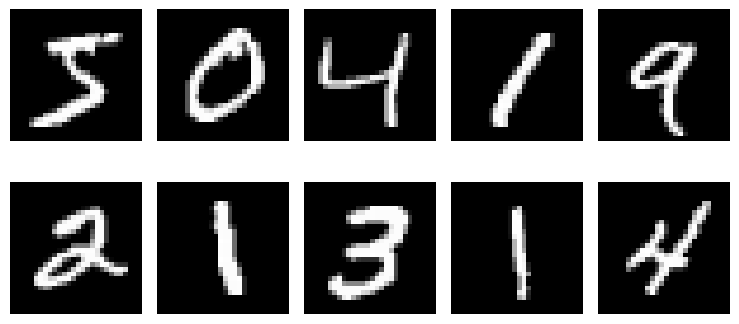

In [4]:
print("Training data: {} {}".format(x_train.shape, y_train.shape))
print("Test data: {} {}".format(x_val.shape, y_val.shape))
show_images(x_train)

# Activation Functions & Optimizers

There are many activation functions which some of them listed below. In this section you should implement them.

1. Sigmoid:
$$
\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}
$$

2. Softmax: $$\operatorname{softmax}(\mathbf X)_{ij} = \frac{\exp(\mathbf X_{ij})}{\sum_k \exp \mathbf X_{ik})}.$$


3. Tanh (Hyperbolic Tangent):
$$
\operatorname{tanh}(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}
$$

4. ReLU: $$\operatorname{ReLU}(x) = \max(0, x)$$

5. Leaky ReLU:
$$
\operatorname{LeakyReLU}(x) =
\begin{cases}
x & \text{if } x \geq 0 \\
\alpha x & \text{if } x < 0
\end{cases}
$$
where \( $\alpha$ \) is a small constant (e.g., 0.01).

6. ELU (Exponential Linear Unit):
$$
\operatorname{ELU}(x) =
\begin{cases}
x & \text{if } x > 0 \\
\alpha (\exp(x) - 1) & \text{if } x \leq 0
\end{cases}
$$
where ($\alpha$) is a positive constant.

7. SELU (Scaled Exponential Linear Unit):
$$
\operatorname{SELU}(x) =
\lambda
\begin{cases}
x & \text{if } x > 0 \\
\alpha (\exp(x) - 1) & \text{if } x \leq 0
\end{cases}
$$
where \( $\lambda$ \) and \( $\alpha$ \) are predefined constants, typically \( $\lambda \approx 1.0507$ \) and \( $\alpha \approx 1.67326$ \).


------
There are several optimizer algorithms for optimizing the neural network over epochs. You should implement some of those mentioned in this section:

***Stochastic Gradient Descent (SGD)***

SGD is the basic form of gradient descent, where each weight (\( w \)) and bias (\( b \)) parameter is updated in the opposite direction of its gradient.

**Update Rule:**
$$
w^{(t+1)} = w^{(t)} - \eta \cdot \nabla_w L(w^{(t)}, b^{(t)})
$$
$$
b^{(t+1)} = b^{(t)} - \eta \cdot \nabla_b L(w^{(t)}, b^{(t)})
$$

- \( w \): Weight parameters
- \( b \): Bias parameters
- \( $\eta$ \): Learning rate
- \( $\nabla_w L(w, b)$ \): Gradient of the loss with respect to \( w \)
- \( $\nabla_b L(w, b)$ \): Gradient of the loss with respect to \( b \)

<br><br>

***Momentum Optimizer***

Momentum optimizer smooths parameter updates by adding a velocity term to accumulate past gradients.

**Update Rule:**
1. **Velocity Update for Weights and Biases:**
   $$
   v_w^{(t+1)} = \beta \cdot v_w^{(t)} + (1 - \beta) \cdot \nabla_w L(w^{(t)}, b^{(t)})
   $$
   $$
   v_b^{(t+1)} = \beta \cdot v_b^{(t)} + (1 - \beta) \cdot \nabla_b L(w^{(t)}, b^{(t)})
   $$

2. **Parameter Update:**
   $$
   w^{(t+1)} = w^{(t)} - \eta \cdot v_w^{(t+1)}
   $$
   $$
   b^{(t+1)} = b^{(t)} - \eta \cdot v_b^{(t+1)}
   $$

- \( $v_w$ \): Velocity term for weights
- \( $v_b$ \): Velocity term for biases
- \( $\beta$ \): Momentum term, typically set to 0.9

<br><br>

***Adam Optimizer***

Adam combines momentum and adaptive learning rates, using both first (momentum) and second (RMSprop) moment estimates.

**Update Rule:**
1. **Compute biased first and second moment estimates:**
   $$
   m_w^{(t+1)} = \beta_1 \cdot m_w^{(t)} + (1 - \beta_1) \cdot \nabla_w L(w^{(t)}, b^{(t)})
   $$
   $$
   m_b^{(t+1)} = \beta_1 \cdot m_b^{(t)} + (1 - \beta_1) \cdot \nabla_b L(w^{(t)}, b^{(t)})
   $$
   $$
   v_w^{(t+1)} = \beta_2 \cdot v_w^{(t)} + (1 - \beta_2) \cdot \left( \nabla_w L(w^{(t)}, b^{(t)}) \right)^2
   $$
   $$
   v_b^{(t+1)} = \beta_2 \cdot v_b^{(t)} + (1 - \beta_2) \cdot \left( \nabla_b L(w^{(t)}, b^{(t)}) \right)^2
   $$

2. **Compute bias-corrected estimates:**
   $$
   \hat{m}_w^{(t+1)} = \frac{m_w^{(t+1)}}{1 - \beta_1^{t+1}}, \quad \hat{m}_b^{(t+1)} = \frac{m_b^{(t+1)}}{1 - \beta_1^{t+1}}
   $$
   $$
   \hat{v}_w^{(t+1)} = \frac{v_w^{(t+1)}}{1 - \beta_2^{t+1}}, \quad \hat{v}_b^{(t+1)} = \frac{v_b^{(t+1)}}{1 - \beta_2^{t+1}}
   $$

3. **Parameter Update:**
   $$
   w^{(t+1)} = w^{(t)} - \eta \cdot \frac{\hat{m}_w^{(t+1)}}{\sqrt{\hat{v}_w^{(t+1)}} + \epsilon}
   $$
   $$
   b^{(t+1)} = b^{(t)} - \eta \cdot \frac{\hat{m}_b^{(t+1)}}{\sqrt{\hat{v}_b^{(t+1)}} + \epsilon}
   $$

- \( $m_w$ \), \( $m_b$ \): First moment estimates (mean of gradients) for weights and biases
- \( $v_w$ \), \( $v_b$ \): Second moment estimates (uncentered variance of gradients) for weights and biases
- \( $\beta_1$ \): Decay rate for first moment, typically 0.9
- \( $\beta_2$ \): Decay rate for second moment, typically 0.999
- \( $\epsilon$ \): Small constant for numerical stability (e.g., \(10^{-8}\))

# MLP from Scratch

In [5]:
class MLP:
    def __init__(self, sizes, activation='relu'):
        self.sizes = sizes
        self.num_layers = len(sizes) - 1
        self.activation_name = activation
        self.params = self.initialize_weights()
        self.cache = {}

        # Activation functions
        activations = {
            'relu': self.relu,
            'sigmoid': self.sigmoid,
            'tanh': self.tanh,
            'leaky_relu': self.leaky_relu,
            'selu': self.selu,
            'elu':self.elu,
        }
        self.activation = activations.get(activation)
        if not self.activation:
            raise ValueError(f"Unsupported activation: {activation}")

    def initialize_weights(self):
        params = {}
        for i in range(1, self.num_layers + 1):
            input_size = self.sizes[i - 1]
            output_size = self.sizes[i]
            params[f"W{i}"] = np.random.randn(output_size, input_size) * np.sqrt(2. / input_size)
            params[f"b{i}"] = np.zeros((output_size, 1))
        return params

    def relu(self, x, derivative=False):
        if derivative:
            return np.where(x > 0, 1, 0)
        return np.maximum(0, x)

    def sigmoid(self, x, derivative=False):
        sigmoid = 1 / (1 + np.exp(-x))
        if derivative:
            return sigmoid * (1 - sigmoid)
        return sigmoid

    def tanh(self, x, derivative=False):
        tanh = np.tanh(x)
        if derivative:
            return 1 - tanh ** 2
        return tanh

    def leaky_relu(self, x, alpha=0.01, derivative=False):
        if derivative:
            return np.where(x > 0, 1, alpha)
        return np.where(x > 0, x, alpha * x)


    def elu(self, x, alpha=1.0, derivative=False):
        if derivative:
            return np.where(x > 0, 1, alpha * np.exp(x))
        return np.where(x > 0, x, alpha * (np.exp(x) - 1))

    def selu(self, x, derivative=False):
        alpha = 1.67326
        lambda_ = 1.0507
        if derivative:
            # Derivative of SELU
            return lambda_ * (np.where(x > 0, 1, alpha * np.exp(x)))
        return lambda_ * np.where(x > 0, x, alpha * (np.exp(x) - 1))

    def feed_forward(self, x):
        self.cache['A0'] = x.T
        for i in range(1, self.num_layers + 1):
            Z = np.dot(self.params[f"W{i}"], self.cache[f"A{i-1}"]) + self.params[f"b{i}"]
            A = self.activation(Z) if i != self.num_layers else self.softmax(Z)
            self.cache[f"Z{i}"] = Z
            self.cache[f"A{i}"] = A
        return self.cache[f"A{self.num_layers}"].T

    def back_propagate(self, y, output):
        m = y.shape[0]
        grads = {}
        dA = output.T - y.T  # Cross-entropy loss derivative

        for i in reversed(range(1, self.num_layers + 1)):
            dZ = dA if i == self.num_layers else dA * self.activation(self.cache[f"Z{i}"], derivative=True)
            dW = np.dot(dZ, self.cache[f"A{i-1}"].T) / m
            db = np.sum(dZ, axis=1, keepdims=True) / m
            dA = np.dot(self.params[f"W{i}"].T, dZ) if i > 1 else None
            grads[f"W{i}"] = dW
            grads[f"b{i}"] = db
        return grads

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)

    def cross_entropy_loss(self, y, output):
        m = y.shape[0]
        output = np.clip(output, 1e-9, 1 - 1e-9)
        return -np.sum(y * np.log(output)) / m

    def update_weights(self, grads, lr):
        for i in range(1, self.num_layers + 1):
            self.params[f"W{i}"] -= lr * grads[f"W{i}"]
            self.params[f"b{i}"] -= lr * grads[f"b{i}"]

    def accuracy(self, y, output):
        predictions = np.argmax(output, axis=1)
        labels = np.argmax(y, axis=1)
        return np.mean(predictions == labels)

    def train(self, x_train, y_train, x_val, y_val, epochs=100, batch_size=64, lr=0.01):
        num_batches = -(-x_train.shape[0] // batch_size)
        for epoch in range(epochs):
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            for batch in range(num_batches):
                start = batch * batch_size
                end = min(start + batch_size, x_train.shape[0])
                x_batch = x_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]

                output = self.feed_forward(x_batch)
                grads = self.back_propagate(y_batch, output)
                self.update_weights(grads, lr)

            # Metrics
            train_output = self.feed_forward(x_train)
            train_loss = self.cross_entropy_loss(y_train, train_output)
            train_acc = self.accuracy(y_train, train_output)
            val_output = self.feed_forward(x_val)
            val_loss = self.cross_entropy_loss(y_val, val_output)
            val_acc = self.accuracy(y_val, val_output)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Please run experiments with different combinations of optimizers (SGD, Momentum, and Adam) and activation functions (ReLU, Sigmoid, Tanh, Leaky ReLU, SELU, and ELU) over 20 epochs each. Consider networks with three layers (without input layer) whose number of neurons is 128, 64 and 10 respectively. Also consider two learning rates 0.01 and 0.001.


After testing all combinations, report which combination of optimizer, activation function, and learning rate performs best.




In [ ]:
sizes = [784, 128, 64, 10]

activation_functions = ['sigmoid', 'relu', 'tanh', 'leaky_relu', 'selu', 'elu']
optimizers = ['sgd', 'momentum', 'adam']
learning_rates = [0.01, 0.001]

best_model = None
best_accuracy = 0.0
best_config = None

for activation in activation_functions:
    for optimizer in optimizers:
        for lr in learning_rates:
            mlp = MLP(sizes, activation)
            mlp.optimizer = optimizer
            mlp.train(x_train, y_train, x_val, y_val, epochs=15, batch_size=64, lr=lr)
            print(f"Trained with {activation} activation, {optimizer} optimizer, lr={lr}")


Epoch 1/15, Train Loss: 2.1605, Train Acc: 0.4345, Val Loss: 2.1575, Val Acc: 0.4379
Epoch 2/15, Train Loss: 1.8956, Train Acc: 0.6077, Val Loss: 1.8881, Val Acc: 0.6054
Epoch 3/15, Train Loss: 1.5193, Train Acc: 0.6818, Val Loss: 1.5078, Val Acc: 0.6847
Epoch 4/15, Train Loss: 1.2023, Train Acc: 0.7402, Val Loss: 1.1905, Val Acc: 0.7429
Epoch 5/15, Train Loss: 0.9804, Train Acc: 0.7891, Val Loss: 0.9679, Val Acc: 0.7929
Epoch 6/15, Train Loss: 0.8287, Train Acc: 0.8079, Val Loss: 0.8155, Val Acc: 0.8140
Epoch 7/15, Train Loss: 0.7220, Train Acc: 0.8304, Val Loss: 0.7075, Val Acc: 0.8360
Epoch 8/15, Train Loss: 0.6441, Train Acc: 0.8453, Val Loss: 0.6290, Val Acc: 0.8513
Epoch 9/15, Train Loss: 0.5853, Train Acc: 0.8557, Val Loss: 0.5699, Val Acc: 0.8626
Epoch 10/15, Train Loss: 0.5399, Train Acc: 0.8640, Val Loss: 0.5243, Val Acc: 0.8710
Epoch 11/15, Train Loss: 0.5041, Train Acc: 0.8708, Val Loss: 0.4886, Val Acc: 0.8782
Epoch 12/15, Train Loss: 0.4750, Train Acc: 0.8773, Val Loss: 0

# MLP as function Approximator
We know that a MLP with one hidden layer could  approximate any smooth function! <br> Here you will manually fit a sine function using ReLU activation. <br>You need to set the correct weights on ReLUs so the linear combination approximates the desired function.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def relu_approximation(input_data, target_labels):
    """
    Args:
      input_data: torch.tensor
        Input training data (1D tensor)
      target_labels: torch.tensor
        Ground truth labels for training data (1D tensor)

    Returns:
      predicted_labels: torch.tensor
        Estimated labels or class predictions
        Derived from weighted sum of ReLU activations along the x-axis
      activation_map: torch.tensor
        ReLU activations computed across the x-axis
      x_points: torch.tensor
        Points along the x-axis
    """
    num_relus = input_data.shape[0] - 1

    x_points = torch.linspace(torch.min(input_data), torch.max(input_data), 1000)

    biases = torch.linspace(torch.min(input_data), torch.max(input_data), num_relus)

    activation_map = torch.zeros((num_relus, len(x_points)))

    for relu_idx in range(num_relus):
        activation_map[relu_idx, :] = torch.relu(x_points - biases[relu_idx])


    activation_map_training = torch.zeros((num_relus, len(input_data)))
    for relu_idx in range(num_relus):
        activation_map_training[relu_idx, :] = torch.relu(input_data.flatten() - biases[relu_idx])

    # Solve the least squares problem
    relu_weights = torch.linalg.lstsq(activation_map_training.T, target_labels).solution

    # Use activation map to compute predictions
    predicted_labels = (activation_map.T @ relu_weights).flatten()  # Change to activation_map.T for correct shape

    return predicted_labels, activation_map, x_points


def plot_function_apx(x_points, activation_map, predicted_output, input_data, target_labels):
    """Plot the true sine function, ReLU approximation, and individual ReLU activations."""
    plt.figure(figsize=(10, 6))

    plt.plot(input_data, target_labels, label="True Sine Function", color="blue", linewidth=2)

    plt.plot(x_points, predicted_output.detach().numpy(), label="ReLU Approximation", color="red", linestyle="--")

    for i in range(activation_map.shape[0]):
        plt.plot(x_points, activation_map[i, :].detach().numpy(), linestyle=":", label=f"ReLU {i+1}")

    plt.legend()
    plt.title("Sine Function Approximation Using ReLU")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.grid()
    plt.show()


# Example usage
num_samples = 10
input_data = torch.linspace(0, 2 * np.pi, num_samples).view(-1, 1)
target_labels = torch.sin(input_data)

predicted_output, activation_map, x_points = relu_approximation(input_data, target_labels)

plot_function_apx(x_points, activation_map, predicted_output, input_data, target_labels)


# Depth vs. Width
Here we wanna see the effect of width vs. depth on a classification task.First you are going to implement MLP again; But with 2 differences: <br>

1.   It is general purpose (i.e. works for desired depth and activation functions)
2.   You will implement it using pytorch



In [ ]:
class MLP_pytorch(nn.Module):
    """
    Simulate MLP Network
    """

    def __init__(self, activation_fn, input_feature_num, hidden_unit_nums, output_feature_num):
        """
        Initialize MLP Network parameters

        Args:
          activation_fn: string
            Activation function ('ReLU', 'Tanh', 'Sigmoid')
          input_feature_num: int
            Number of input features
          hidden_unit_nums: list
            Number of units per hidden layer. List of integers
          output_feature_num: int
            Number of output features

        Returns:
          Nothing
        """
        super(MLP_pytorch, self).__init__()
        self.input_feature_num = input_feature_num
        self.mlp = nn.Sequential()

        in_num = input_feature_num

        # Add hidden layers with activation functions
        for i, out_num in enumerate(hidden_unit_nums):
            self.mlp.add_module(f'Linear_{i}', nn.Linear(in_num, out_num))

            # Add activation function based on the input argument
            if activation_fn == 'ReLU':
                self.mlp.add_module(f'ReLU_{i}', nn.ReLU())
            elif activation_fn == 'Tanh':
                self.mlp.add_module(f'Tanh_{i}', nn.Tanh())
            elif activation_fn == 'Sigmoid':
                self.mlp.add_module(f'Sigmoid_{i}', nn.Sigmoid())
            else:
                raise ValueError(f"Unsupported activation function: {activation_fn}")

            in_num = out_num

        # Add the output layer
        out_layer = nn.Linear(in_num, output_feature_num)
        self.mlp.add_module('Output_Linear', out_layer)

    def forward(self, x):
        """
        Simulate forward pass of MLP Network

        Args:
          x: torch.tensor
            Input data

        Returns:
          logits: torch.tensor
            Output after forward pass
        """
        # Reshape inputs to (batch_size, input_feature_num)
        x = x.view(-1, self.input_feature_num)
        logits = self.mlp(x)  # Forward pass
        return logits


Now let's make a spiral dataset that follows this formula:
\begin{equation}
\begin{array}{c}
X_{k}(t)=t\left(\begin{array}{c}
\sin \left[\frac{2 \pi}{K}\left(2 t+k-1\right)\right]+\mathcal{N}\left(0, \sigma\right) \\
\cos \left[\frac{2 \pi}{K}\left(2 t+k-1\right)\right]+\mathcal{N}\left(0, \sigma\right)
\end{array}\right)
\end{array}, \quad 0 \leq t \leq 1, \quad k=1, \ldots, K
\end{equation}

Run cell below to create the data and load it as tensors.

In [ ]:
# @title Data Loader
K = 4
sigma = 0.4
N = 1000
t = torch.linspace(0, 1, N)
X = torch.zeros(K*N, 2)
y = torch.zeros(K*N)
for k in range(K):
  X[k*N:(k+1)*N, 0] = t*(torch.sin(2*np.pi/K*(2*t+k)) + sigma**2*torch.randn(N))
  X[k*N:(k+1)*N, 1] = t*(torch.cos(2*np.pi/K*(2*t+k)) + sigma**2*torch.randn(N))
  y[k*N:(k+1)*N] = k


X_test, y_test, X_train, y_train = shuffle_and_split_data(X, y, seed=SEED)

# DataLoader with random seed
batch_size = 128
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                         )

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )

Now we will add more polynomial features to the dataset to make the first layer wider. Afterwards, train a single linear layer. We could use the same MLP network with no hidden layers (though it would not be called an MLP anymore!).

Add polynomial terms up to $P=50$ which means that for every $x_1^n x_2^m$ term, $n+m\leq P$. Total number of polynomial features up to $P$ follows this formula:

\begin{equation}
\text{# of terms} = \frac{(P+1)(P+2)}{2}
\end{equation}

Also, we don't need the polynomial term with degree zero (which is the constatnt term) since `nn.Linear` layers have bias terms. Therefore we will have one fewer polynomial feature.

In [ ]:
def polynomial_classifier(poly_degree, seed=0):
    """
    Helper function to run the polynomial classifier

    Args:
      poly_degree: int
        Degree of the polynomial
      seed: int
        A non-negative integer that defines the random state.

    Returns:
      num_features: int
        Number of features
    """

    def polynomial_features(poly_degree, X):
        """
        Function to define the number of polynomial features except the bias term

        Args:
          poly_degree: int
            Degree of the polynomial
          X: torch.tensor
            Input data

        Returns:
          poly_X: torch.tensor
            Polynomial terms
          num_features: int
            Number of features
        """
        n_samples, n_features = X.shape

        poly_X = []
        for degree in range(1, poly_degree + 1):
            for combo in combinations_with_replacement(range(n_features), degree):
                poly_X.append(torch.prod(X[:, combo], dim=1).view(-1, 1))

        poly_X = torch.cat(poly_X, dim=1)
        num_features = poly_X.shape[1]

        return poly_X, num_features

    ############################################################
    poly_X_test, num_features = polynomial_features(poly_degree, X_test)
    poly_X_train, _ = polynomial_features(poly_degree, X_train)

    batch_size = 128
    g_seed = torch.Generator()
    g_seed.manual_seed(seed)
    poly_test_data = TensorDataset(poly_X_test, y_test)
    poly_test_loader = DataLoader(poly_test_data,
                                  batch_size=batch_size,
                                  shuffle=False,
                                  num_workers=1,
                                  worker_init_fn=seed_worker,
                                  generator=g_seed)

    poly_train_data = TensorDataset(poly_X_train, y_train)
    poly_train_loader = DataLoader(poly_train_data,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   num_workers=1,
                                   worker_init_fn=seed_worker,
                                   generator=g_seed)

    ############################################################
    poly_net = MLP_pytorch('relu', num_features, [], K)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(poly_net.parameters(), lr=1e-3)
    _, _ = train_test_classification(poly_net, criterion, optimizer,
                                     poly_train_loader, poly_test_loader,
                                     num_epochs=100)

    X_all = sample_grid()
    poly_X_all, _ = polynomial_features(poly_degree, X_all)
    y_pred = poly_net(poly_X_all)

    plot_decision_map(X_all.cpu(), y_pred.cpu(), X_test.cpu(), y_test.cpu())
    plt.show()

    return num_features


### Train the network. How does it generalize?

In [ ]:
seed_setter(seed=SEED)
max_poly_deg = 50
num_features = polynomial_classifier(max_poly_deg)
print(f'Number of features: {num_features}')

Now create another instance of `MLP_pytorch` class having a hidden layer of 128 neurons and train it. Compare the result with the wide network. How does deeper model generalize? Is the decision boundaries ideal? Why?

In [ ]:
##############################----##############################
seed_setter(SEED)
net2 = MLP_pytorch('ReLU', X.shape[1], [128], K)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net2.parameters(), lr=1e-3)
num_epochs = 100

_, _ = train_test_classification(net2, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True)

X_all = sample_grid()
y_pred = net2(X_all).cpu()
plot_decision_map(X_all, y_pred, X_test, y_test)

##############################------##############################